# Currency exchange
## 1. [Always execute](#always)
## 1.1 [Colombian Peso](#colombian)
## 2. [One day forecast](#one_day)
## 3. [Two day forecast](#two_day)
## 4. [Three days forecast](#three_day)
## 5. [Four days forecast](#four_day)
## 6. [Five days forecast](#five_day)
## 7. [Six days forecast](#six_day)
## 8. [Seven days forecast](#seven_day)
# Always Execute <a href='always'>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as k
import pandas_profiling as pdp
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import os

Using TensorFlow backend.


# End of Always execute

In [2]:
df = pd.read_csv('Datasets/Currency/Foreign_Exchange_Rates.csv', na_values='ND', index_col=0)
df.head()

,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,INDIA - INDIAN RUPEE/US$,...,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.8050,1.4465,8.2798,7.7765,43.55,...,1.6563,7.3290,101.70,3.8,7.964,8.4430,72.30,1.5808,31.38,36.97
1,2000-01-04,1.5239,0.9700,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,...,1.6535,7.2180,103.09,3.8,7.934,8.3600,72.65,1.5565,30.60,37.13
2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.8560,1.4518,8.2798,7.7780,43.55,...,1.6560,7.2080,103.77,3.8,7.935,8.3530,72.95,1.5526,30.80,37.10
3,2000-01-06,1.5291,0.9686,1.9436,0.6070,1.8400,1.4571,8.2797,7.7785,43.55,...,1.6655,7.2125,105.19,3.8,7.940,8.3675,72.95,1.5540,31.75,37.62
4,2000-01-07,1.5272,0.9714,1.9380,0.6104,1.8310,1.4505,8.2794,7.7783,43.55,...,1.6625,7.2285,105.17,3.8,7.966,8.4150,73.15,1.5623,30.85,37.30


In [3]:
pdp.ProfileReport(df)

Number of variables,23
Number of observations,5217
Total Missing (%),2.1%
Total size in memory,978.2 KiB
Average record size in memory,192.0 B
Numeric,13
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,9


## Empty values 
Percentage of empty values per country currency

In [3]:
df.isnull().sum()*100/df.shape[0]

Time Serie                                   0.000000
AUSTRALIA - AUSTRALIAN DOLLAR/US$            3.795285
EURO AREA - EURO/US$                         3.795285
NEW ZEALAND - NEW ZELAND DOLLAR/US$          3.795285
UNITED KINGDOM - UNITED KINGDOM POUND/US$    3.795285
BRAZIL - REAL/US$                            3.795285
CANADA - CANADIAN DOLLAR/US$                 3.795285
CHINA - YUAN/US$                             3.776117
HONG KONG - HONG KONG DOLLAR/US$             3.795285
INDIA - INDIAN RUPEE/US$                     3.814453
KOREA - WON/US$                              3.795285
MEXICO - MEXICAN PESO/US$                    3.795285
SOUTH AFRICA - RAND/US$                      3.795285
SINGAPORE - SINGAPORE DOLLAR/US$             3.795285
DENMARK - DANISH KRONE/US$                   3.795285
JAPAN - YEN/US$                              3.795285
MALAYSIA - RINGGIT/US$                       3.795285
NORWAY - NORWEGIAN KRONE/US$                 3.795285
SWEDEN - KRONA/US$          

For purposes of the experiment I will interpolate the empty values in order to not have missing information in any currecy.

In [3]:
df.interpolate(inplace=True)

[Text(0, 0.5, 'Currency Value'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Euro value per time vs US dollar')]

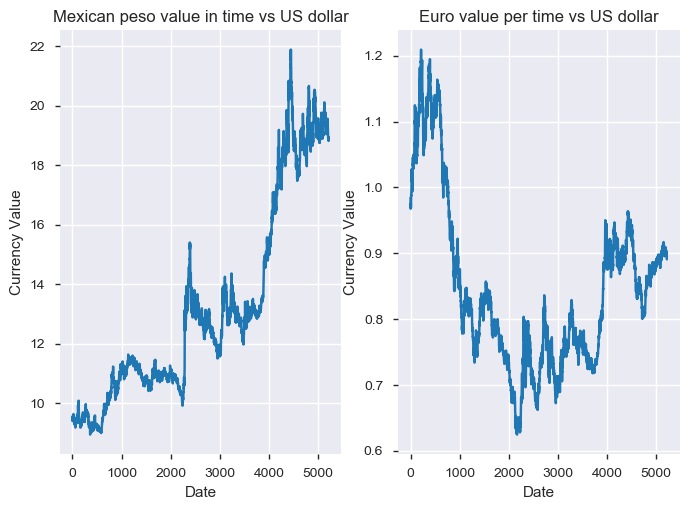

In [9]:
fig, (ax_e, ax_i) = plt.subplots(1,2, sharex=True)
ax_e.plot(df['MEXICO - MEXICAN PESO/US$'], label = 'Mexican Peso')
ax_e.set(title='Mexican peso value in time vs US dollar', xlabel='Date', ylabel='Currency Value')

ax_i.plot(df['EURO AREA - EURO/US$'], label = 'Euro')
ax_i.set(title='Euro value per time vs US dollar', xlabel='Date', ylabel='Currency Value')


## Time series forecasting.
A very used method for time series forecasting is recurrent neural networks. For this method the data must have 3 dimensions. The batch size, the time window and the actual values in the timeseries. Since I will be doing one currency it will be a univariate time series. This means the secodn and third dimensions are of size one.

In [4]:
np_mexico = df['MEXICO - MEXICAN PESO/US$'].values.reshape(-1,1)
np_euro = df['EURO AREA - EURO/US$'].values.reshape(-1,1)

## Model for Mexican peso
The entries in the dataset were per day. Therefore, I decided to create a model that forecasts the price of the mexican peso using the last 2 months of data as input. For training I will use the earlier esntries and test against the last 1000 entries of the dataset.

First normalization is required. I will use min max scaler. There is a fucntion in sklearn, however I will do it manuaaly for fun.

In [5]:
max_mexico, min_mexico = np_mexico.min(), np_mexico.max()
np_mexico = (np_mexico-min_mexico)/(max_mexico-min_mexico)

In [6]:
trn = np_mexico[:-1000]
tst = np_mexico[-1000:]
print(trn.shape, tst.shape)

(4217, 1) (1000, 1)


In [8]:
def build_trn(ts_length, data):
    x, y = [], []
    for i in range(len(data)-ts_length-1):
        x.append(data[i:(i+ts_length),0])
        y.append(data[i+ts_length,0])
    return np.array(x),np.array(y)

In [8]:
window_size = 14
X_trn, y_trn = build_trn(window_size, trn)
X_trn = np.expand_dims(X_trn,-1)
print(X_trn.shape, y_trn.shape)
X_tst,y_tst = build_trn(window_size,tst)
X_tst = np.expand_dims(X_tst, -1)
print(X_tst.shape, y_tst.shape)

(4202, 14, 1) (4202,)
(985, 14, 1) (985,)


In [9]:
input_layer = k.layers.Input(X_trn.shape[1:])
hidden_layer = k.layers.CuDNNGRU(64)(input_layer)
output_layer = k.layers.Dense(1)(hidden_layer)
model = k.Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 14, 1)             0         
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 64)                12864     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [10]:
opt = k.optimizers.adam(lr=0.001)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_trn, y_trn, epochs=10, batch_size=32, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
4202/4202 [==============================] - 2s 473us/step - loss: 0.0501
Epoch 2/10
4202/4202 [==============================] - 0s 86us/step - loss: 0.0015
Epoch 3/10
4202/4202 [==============================] - 0s 87us/step - loss: 3.4830e-04
Epoch 4/10
4202/4202 [==============================] - 0s 88us/step - loss: 1.2213e-04
Epoch 5/10
4202/4202 [==============================] - 0s 86us/step - loss: 1.1078e-04
Epoch 6/10
4202/4202 [==============================] - 0s 87us/step - loss: 1.0638e-04
Epoch 7/10
4202/4202 [==============================] - 0s 86us/step - loss: 1.0247e-04
Epoch 8/10
4202/4202 [==============================] - 0s 87us/step - loss: 9.9620e-05
Epoch 9/10
4202/4202 [==============================] - 0s 92us/step - loss: 9.5692e-05
Epoch 10/10
4202/4202 [==============================] - 0s 92us/step - loss: 9.2834e-05


## Recovering original values

In [11]:
y_hat = model.predict(X_tst)
y_hat = ((max_mexico-min_mexico)*y_hat) + min_mexico
y_tst = ((max_mexico-min_mexico)*y_tst) + min_mexico

<Figure size 720x720 with 0 Axes>

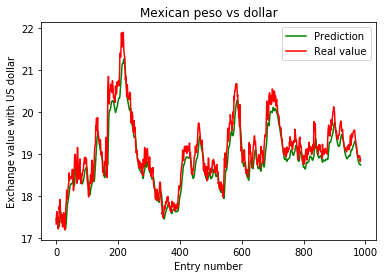

<Figure size 720x720 with 0 Axes>

In [12]:
plt.plot(y_hat, label='Prediction', color='green')
plt.plot(y_tst, label='Real value', color='red')
plt.legend()
plt.title('Mexican peso vs dollar')
plt.xlabel('Entry number')
plt.ylabel('Exchange value with US dollar')
plt.figure(figsize=(10,10))

In [13]:
mse = (np.mean((y_hat-y_tst)**2))**0.5
print(mse)

1.1233468750626654


## Analysis the model learning curve

Text(0, 0.5, 'MSE')

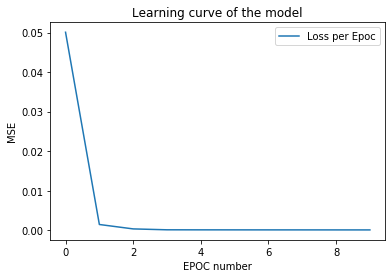

In [14]:
plt.plot(history.history['loss'], label='Loss per Epoc')
plt.title('Learning curve of the model')
plt.xlabel('EPOC number')
plt.legend()
plt.ylabel('MSE')

## Colombian Peso <a name='colombian'></a>

In [2]:
df_colombia = pd.read_excel("Datasets/Currency/PesoCol.xlsx", names=['Date','Euro','Rate'])
df_colombia.head()

,Date,Euro,Rate
0,01/02/2018,3535.87436,2835.05
1,02/02/2018,3490.93614,2806.67
2,03/02/2018,3522.60329,2832.13
3,04/02/2018,3522.60329,2832.13
4,05/02/2018,3517.78867,2832.13


Normalization using sklearn function.

In [3]:
scaler = MinMaxScaler()
temp_col = np.array(df_colombia.Rate).reshape(-1,1)
temp_col = scaler.fit_transform(temp_col)
X = temp_col[:-200]
y = temp_col[-200:]

In [4]:
def build_sequences(data, window_size, target_distance):
    inputs = []
    targets = []
    for i in range(len(data)-(window_size+target_distance)):
        inputs.append(data[i:i+window_size])
        targets.append(data[i+window_size+target_distance]) # Tight now it takes the target being certain days ahead. 
        # A different approach could be to do spaced TS. Every two days to forecast two days ahead in time.
    return np.array(inputs), np.array(targets)
def build_sequences_separation(data, window_size, target_distance, separation):
    inputs = []
    targets = []
    window_size = window_size*separation
    for i in range(len(data)-(window_size+target_distance)):
        inputs.append(data[i:i+window_size:separation])
        targets.append(data[i+window_size+target_distance]) # Right now it takes the target being certain days ahead. 
        # A different approach could be to do spaced TS. Every two days to forecast two days ahead in time.
    return np.array(inputs), np.array(targets)

## One day forecast <a name='one_day'></a>

In [5]:
window_size = 14
days_ahead_forecast = 0
separation = 1
X_trn, y_trn = build_sequences(X, window_size, days_ahead_forecast)
print(X_trn.shape, y_trn.shape)
X_tst,y_tst = build_sequences(y, window_size, days_ahead_forecast)
print(X_tst.shape, y_tst.shape)

(890, 14, 1) (890, 1)
(186, 14, 1) (186, 1)


In [6]:
input_layer = k.layers.Input(X_trn.shape[1:])
hidden_layer = k.layers.CuDNNGRU(64, return_sequences=True)(input_layer)
hidden_layer = k.layers.CuDNNGRU(64)(hidden_layer)
output_layer = k.layers.Dense(1)(hidden_layer)
model = k.Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
checkpoint_path = "checkpoints/one_day.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

opt = k.optimizers.adam(lr=0.001)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_trn, y_trn, epochs=15, batch_size=32, verbose=0, callbacks=[cp_callback])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: saving model to checkpoints/one_day.ckpt

Epoch 00002: saving model to checkpoints/one_day.ckpt

Epoch 00003: saving model to checkpoints/one_day.ckpt

Epoch 00004: saving model to checkpoints/one_day.ckpt

Epoch 00005: saving model to checkpoints/one_day.ckpt

Epoch 00006: saving model to checkpoints/one_day.ckpt

Epoch 00007: saving model to checkpoints/one_day.ckpt

Epoch 00008: saving model to checkpoints/one_day.ckpt

Epoch 00009: saving model to checkpoints/one_day.ckpt

Epoch 00010: saving model to checkpoints/one_day.ckpt

Epoch 00011: saving model to checkpoints/one_day.ckpt

Epoch 00012: saving model to checkpoints/one_day.ckpt

Epoch 00013: saving model to checkpoints/one_day.ckpt

Epoch 00014: saving model to checkpoints/one_day.ckpt

Epoch 00015: saving model to checkpoints/one_day.ckpt


### Reverse normalization

In [8]:
y_hat = model.predict(X_tst)
y_hat = scaler.inverse_transform(y_hat)
y_tst = scaler.inverse_transform(y_tst)

<Figure size 1296x1296 with 0 Axes>

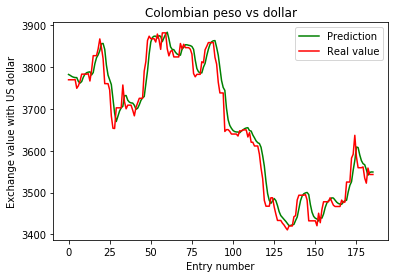

<Figure size 1296x1296 with 0 Axes>

In [9]:
plt.plot(y_hat, label='Prediction', color='green')
plt.plot(y_tst, label='Real value', color='red')
plt.legend()
plt.title('Colombian peso vs dollar')
plt.xlabel('Entry number')
plt.ylabel('Exchange value with US dollar')
plt.figure(figsize=(18,18))

In [10]:
mse = (np.mean((y_hat-y_tst)**2))**0.5
print(mse)

27.82304036761143


## Two days forecast <a name='two_day'></a>
This first model will forecast using daily data and predicting two days ahead in time.

In [11]:
days_ahead_forecast = 1
X_trn, y_trn = build_sequences(X, window_size, days_ahead_forecast)
print(X_trn.shape, y_trn.shape)
X_tst,y_tst = build_sequences(y, window_size, days_ahead_forecast)
print(X_tst.shape, y_tst.shape)
# Creating model
input_layer = k.layers.Input(X_trn.shape[1:])
hidden_layer = k.layers.CuDNNGRU(64, return_sequences=True)(input_layer)
hidden_layer = k.layers.CuDNNGRU(64)(hidden_layer)
output_layer = k.layers.Dense(1)(hidden_layer)
model = k.Model(inputs=input_layer, outputs=output_layer)
# Optimizer and checkpoint
checkpoint_path = "checkpoints/two_day.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

opt = k.optimizers.adam(lr=0.001)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_trn, y_trn, epochs=15, batch_size=32, verbose=0, callbacks=[cp_callback])

(889, 14, 1) (889, 1)
(185, 14, 1) (185, 1)

Epoch 00001: saving model to checkpoints/two_day.ckpt

Epoch 00002: saving model to checkpoints/two_day.ckpt

Epoch 00003: saving model to checkpoints/two_day.ckpt

Epoch 00004: saving model to checkpoints/two_day.ckpt

Epoch 00005: saving model to checkpoints/two_day.ckpt

Epoch 00006: saving model to checkpoints/two_day.ckpt

Epoch 00007: saving model to checkpoints/two_day.ckpt

Epoch 00008: saving model to checkpoints/two_day.ckpt

Epoch 00009: saving model to checkpoints/two_day.ckpt

Epoch 00010: saving model to checkpoints/two_day.ckpt

Epoch 00011: saving model to checkpoints/two_day.ckpt

Epoch 00012: saving model to checkpoints/two_day.ckpt

Epoch 00013: saving model to checkpoints/two_day.ckpt

Epoch 00014: saving model to checkpoints/two_day.ckpt

Epoch 00015: saving model to checkpoints/two_day.ckpt


### Reversing data

In [12]:
y_hat = model.predict(X_tst)
y_hat = scaler.inverse_transform(y_hat)
y_tst = scaler.inverse_transform(y_tst)

<Figure size 1296x1296 with 0 Axes>

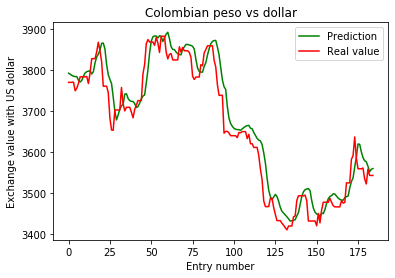

<Figure size 1296x1296 with 0 Axes>

In [13]:
plt.plot(y_hat, label='Prediction', color='green')
plt.plot(y_tst, label='Real value', color='red')
plt.legend()
plt.title('Colombian peso vs dollar')
plt.xlabel('Entry number')
plt.ylabel('Exchange value with US dollar')
plt.figure(figsize=(18,18))

In [14]:
mse = (np.mean((y_hat-y_tst)**2))**0.5
print(mse)

40.79597662416073


### Using model output as input for second forecasting
This model will have daily data and forecast twice, one for the next day and using that as a new input it will forecast the second day.

In [15]:
model.load_weights("checkpoints/one_day.ckpt")

In [16]:
additional_input = model.predict(X_tst)
temp_X_tst = []
for new_i in range(len(additional_input)):
    temp_X_tst.append(np.append(X_tst[new_i][1:], additional_input[new_i]))
temp_X_tst = np.array(temp_X_tst)

In [17]:
temp_X_tst = np.expand_dims(temp_X_tst,-1)

<Figure size 1296x1296 with 0 Axes>

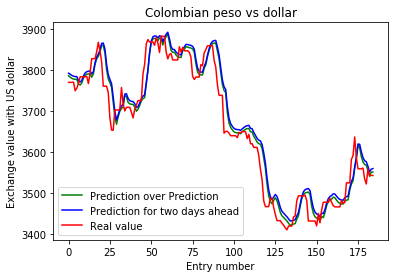

<Figure size 1296x1296 with 0 Axes>

In [18]:
y_hat2 = model.predict(temp_X_tst)
y_hat2 = scaler.inverse_transform(y_hat2)
plt.plot(y_hat2, label='Prediction over Prediction', color='green')
plt.plot(y_hat, label='Prediction for two days ahead', color='blue')
plt.plot(y_tst, label='Real value', color='red')
plt.legend()
plt.title('Colombian peso vs dollar')
plt.xlabel('Entry number')
plt.ylabel('Exchange value with US dollar')
plt.figure(figsize=(18,18))

In [19]:
mse1 = (np.mean((y_hat2-y_tst)**2))**0.5
print(mse1)

37.00391938926203


### Creating model that uses input every two days to predict two days in advance
This model uses as input data the entries of every two days in order to forecast the next entry after two days.

In [20]:
days_ahead_forecast = 0
separation = 2
X_trn, y_trn = build_sequences_separation(X, window_size, days_ahead_forecast,separation)
print(X_trn.shape, y_trn.shape)
X_tst,y_tst = build_sequences_separation(y, window_size, days_ahead_forecast,separation)
print(X_tst.shape, y_tst.shape)
# Creating model
input_layer = k.layers.Input(X_trn.shape[1:])
hidden_layer = k.layers.CuDNNGRU(64, return_sequences=True)(input_layer)
hidden_layer = k.layers.CuDNNGRU(64)(hidden_layer)
output_layer = k.layers.Dense(1)(hidden_layer)
model = k.Model(inputs=input_layer, outputs=output_layer)
# Optimizer and checkpoint
checkpoint_path = "checkpoints/two_day_separation.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

opt = k.optimizers.adam(lr=0.001)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_trn, y_trn, epochs=15, batch_size=32, verbose=0, callbacks=[cp_callback])

(876, 14, 1) (876, 1)
(172, 14, 1) (172, 1)

Epoch 00001: saving model to checkpoints/two_day_separation.ckpt

Epoch 00002: saving model to checkpoints/two_day_separation.ckpt

Epoch 00003: saving model to checkpoints/two_day_separation.ckpt

Epoch 00004: saving model to checkpoints/two_day_separation.ckpt

Epoch 00005: saving model to checkpoints/two_day_separation.ckpt

Epoch 00006: saving model to checkpoints/two_day_separation.ckpt

Epoch 00007: saving model to checkpoints/two_day_separation.ckpt

Epoch 00008: saving model to checkpoints/two_day_separation.ckpt

Epoch 00009: saving model to checkpoints/two_day_separation.ckpt

Epoch 00010: saving model to checkpoints/two_day_separation.ckpt

Epoch 00011: saving model to checkpoints/two_day_separation.ckpt

Epoch 00012: saving model to checkpoints/two_day_separation.ckpt

Epoch 00013: saving model to checkpoints/two_day_separation.ckpt

Epoch 00014: saving model to checkpoints/two_day_separation.ckpt

Epoch 00015: saving model to ch

In [21]:
y_hat3 = model.predict(X_tst)
y_hat3 = scaler.inverse_transform(y_hat3)
y_tst = scaler.inverse_transform(y_tst)

In [22]:
differenceSize = y_hat.shape[0] - y_hat3.shape[0]
y_hat = y_hat[differenceSize:]
y_hat2 = y_hat2[differenceSize:]

<Figure size 1296x1296 with 0 Axes>

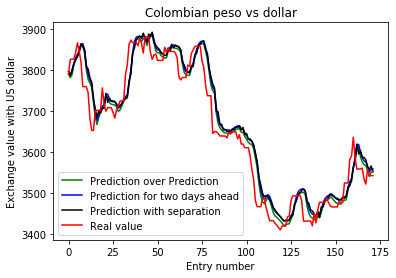

<Figure size 1296x1296 with 0 Axes>

In [23]:
plt.plot(y_hat2, label='Prediction over Prediction', color='green')
plt.plot(y_hat, label='Prediction for two days ahead', color='blue')
plt.plot(y_hat3, label='Prediction with separation', color='black')
plt.plot(y_tst, label='Real value', color='red')
plt.legend()
plt.title('Colombian peso vs dollar')
plt.xlabel('Entry number')
plt.ylabel('Exchange value with US dollar')
plt.figure(figsize=(18,18))

[Text(0, 0.5, 'Difference in COP with real values'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Difference of real value versus third prediction')]

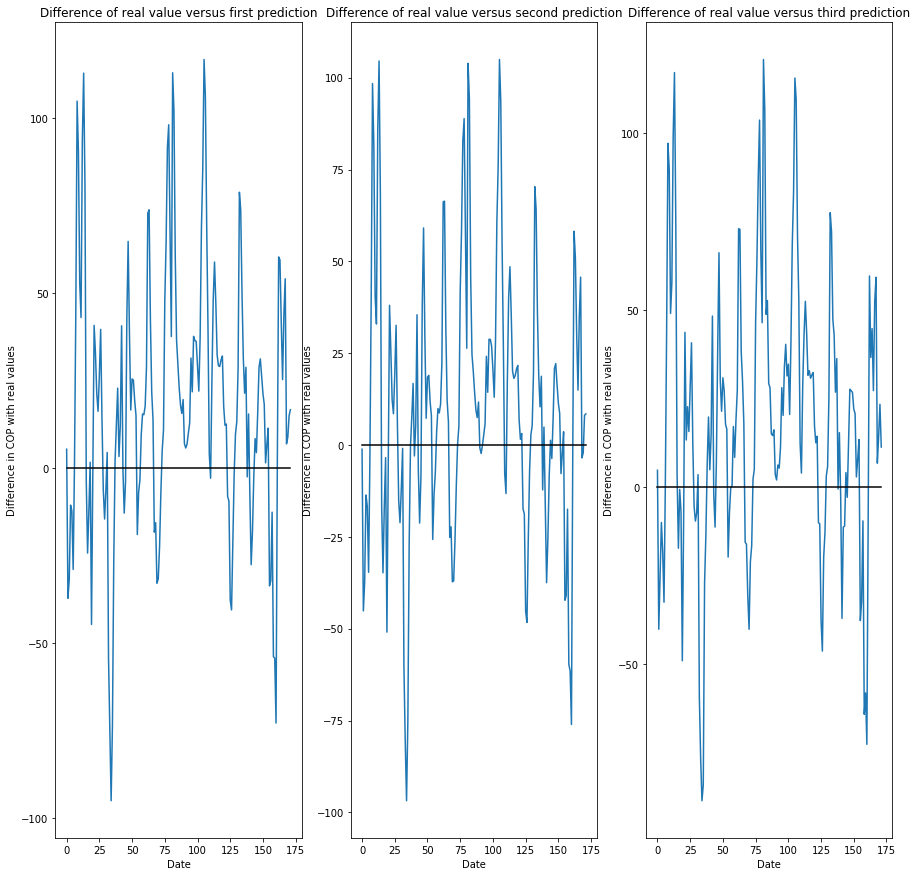

In [24]:
fig, axs = plt.subplots(1,3, sharex=True, figsize=(15,15))
# First subplot
tempAx = axs[0]
tempY = y_hat-y_tst
tempAx.plot(tempY, label='Difference with first model')
tempAx.plot(tempY-tempY, color='black')
tempAx.set(title='Difference of real value versus first prediction', xlabel='Date',ylabel='Difference in COP with real values')

# Second subplot
tempAx = axs[1]
tempY = y_hat2-y_tst
tempAx.plot(tempY, label='Difference with second model')
tempAx.plot(tempY-tempY, color='black')
tempAx.set(title='Difference of real value versus second prediction', xlabel='Date',ylabel='Difference in COP with real values')

# Third subplot
tempAx = axs[2]
tempY = y_hat3-y_tst
tempAx.plot(tempY, label='Difference with third model')
tempAx.plot(tempY-tempY, color='black')
tempAx.set(title='Difference of real value versus third prediction', xlabel='Date',ylabel='Difference in COP with real values')


In [25]:
mse2 = (np.mean((y_hat3-y_tst)**2))**0.5
print("MSE model that has target two days ahead with no separation {0:.2f}".format(mse))
print("MSE model that uses output as input for two day forecast no separation {0:.2f}".format(mse1))
print("MSE model that has input separated every second day {0:.2f}".format(mse2))

MSE model that has target two days ahead with no separation 40.80
MSE model that uses output as input for two day forecast no separation 37.00
MSE model that has input separated every second day 42.66


The plots as well as the mse of each model show that the first model gives a better prediciton in general compare to the other two approaches. The difference plots show the same behavior in all three models. However, the first model has a lower range of error by being more centered around zero in the difference and in general a lower MSE.
## Three days forecast <a name='three_day'></a>
Starting with a model that takes daily entries and predicts the value three days in the future.

In [26]:
days_ahead_forecast = 2
separation = 1
X_trn, y_trn = build_sequences_separation(X, window_size, days_ahead_forecast,separation)
print(X_trn.shape, y_trn.shape)
X_tst,y_tst = build_sequences_separation(y, window_size, days_ahead_forecast,separation)
print(X_tst.shape, y_tst.shape)
# Creating model
input_layer = k.layers.Input(X_trn.shape[1:])
hidden_layer = k.layers.CuDNNGRU(64, return_sequences=True)(input_layer)
hidden_layer = k.layers.CuDNNGRU(64)(hidden_layer)
output_layer = k.layers.Dense(1)(hidden_layer)
model = k.Model(inputs=input_layer, outputs=output_layer)
# Optimizer and checkpoint
checkpoint_path = "checkpoints/3_forecast_no_separation.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

opt = k.optimizers.adam(lr=0.001)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_trn, y_trn, epochs=15, batch_size=32, verbose=0, callbacks=[cp_callback])

(888, 14, 1) (888, 1)
(184, 14, 1) (184, 1)

Epoch 00001: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00002: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00003: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00004: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00005: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00006: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00007: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00008: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00009: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00010: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00011: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00012: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00013: saving model to checkpoints/3_forecast_no_separation.ckpt

Epoch 00014: saving

In [27]:
y_hat = model.predict(X_tst)
y_hat = scaler.inverse_transform(y_hat)
y_tst = scaler.inverse_transform(y_tst)

Using the prediciton for just one day ahead, iterating until the third day.

In [28]:
model.load_weights("checkpoints/one_day.ckpt")

In [40]:
def extend_prediction(model, data, days):
    temp_data = data
    for i in range(days):
        additional_input = model.predict(temp_data)
        temp_data = []
        for new_i in range(len(additional_input)):
            temp_data.append(np.append(data[new_i][1:], additional_input[new_i]))
        temp_data = np.array(temp_data)
        temp_data = np.expand_dims(temp_data,-1)
    return temp_data

In [42]:
temp_X_tst = extend_prediction(model, X_tst, 2)

In [39]:
y_hat2 = model.predict(temp_X_tst)
y_hat2 = scaler.inverse_transform(y_hat2)

<Figure size 1296x1296 with 0 Axes>

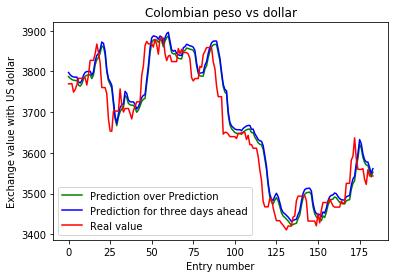

<Figure size 1296x1296 with 0 Axes>

In [44]:
plt.plot(y_hat2, label='Prediction over Prediction', color='green')
plt.plot(y_hat, label='Prediction for three days ahead', color='blue')
plt.plot(y_tst, label='Real value', color='red')
plt.legend()
plt.title('Colombian peso vs dollar')
plt.xlabel('Entry number')
plt.ylabel('Exchange value with US dollar')
plt.figure(figsize=(18,18))

## Four days forecast <a name='four_day'></a>

## Five days forecast <a name='five_day'></a>

## Six days forecast <a name='six_day'></a>

## Seven days forecast <a name='seven_day'></a>